In [1]:
import collections

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data

import sklearn

%matplotlib inline

In [2]:
sklearn.__version__

'0.17.1'

# Load MNIST data using a script in tensorflow
- [MNIST loader in tensorflow](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py)
- Check the scale and distribution of input features. It is **very important** for learning algorithms with gradient descent.

In [3]:
tf_mnist = input_data.read_data_sets('mnist', one_hot=False)
display(tf_mnist.train.images.shape)
display(tf_mnist.validation.images.shape)
display(tf_mnist.train.images.shape)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


(55000, 784)

(5000, 784)

(55000, 784)

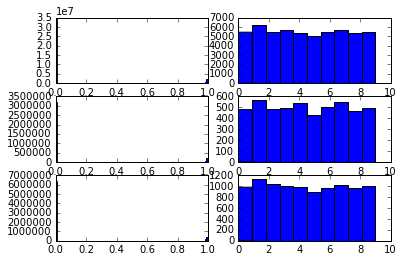

In [4]:
for i, source in enumerate(['train', 'validation', 'test']):
    plt.subplot(3, 2, 2 * i + 1)
    plt.hist(getattr(tf_mnist, source).images.ravel(), bins=100)
    plt.subplot(3, 2, 2 * i + 2)
    plt.hist(getattr(tf_mnist, source).labels)

# Load MNIST data with sklearn
- http://scikit-learn.org/stable/datasets/mldata.html
- http://scikit-learn.org/stable/datasets/#downloading-datasets-from-the-mldata-org-repository

In [5]:
from sklearn.datasets import fetch_mldata
# This creates "scikit_learn_data" under your home directory.
raw = fetch_mldata('MNIST original')

## Check the scale/distribution of data
- The data is sorted by labels. It's important to shuffle them.
- The image data is 256-scale. It is **very important** for algorithms like LogisticRegression to normalie the inputs.
  - It is interesting that LogisticRegression becomes  very slow (10x-20x slower) without this normalization.

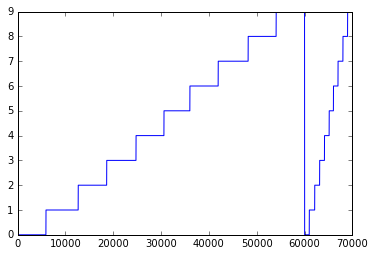

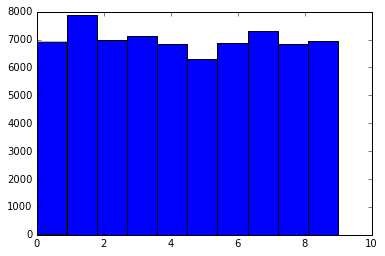

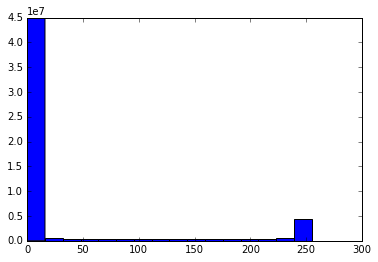

In [6]:
# It's important to shuffle entries.
plt.plot(np.arange(raw.target.shape[0]), raw.target)

plt.show()
plt.hist(raw.target)
plt.show()
# Also, it's important to normalize images to 0-1 scale.
plt.hist(raw.data.ravel(), bins=16)
plt.show()

In [7]:
# Shuffle data
perm = np.arange(raw.data.shape[0])
np.random.shuffle(perm)

shuffled = collections.namedtuple('shuffled', ['data', 'target'])(
    raw.data[perm] / np.float32(raw.data.max()), raw.target[perm]
)

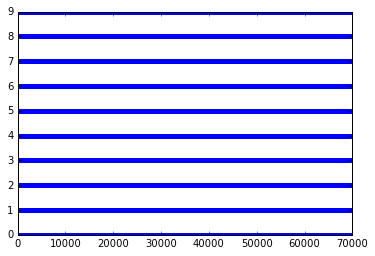

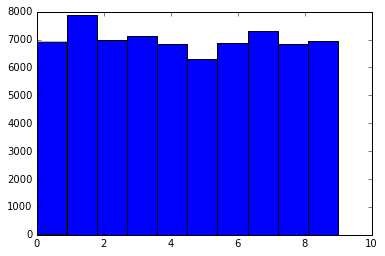

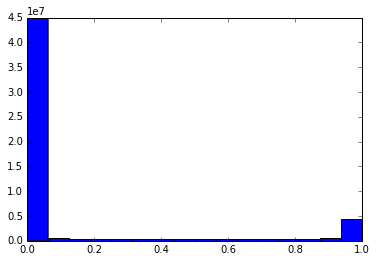

In [8]:
plt.plot(np.arange(shuffled.target.shape[0]), shuffled.target, '.')
plt.show()
plt.hist(shuffled.target)
plt.show()
plt.hist(shuffled.data.ravel(), bins=16)
plt.show()

In [9]:
DataSet = collections.namedtuple('SklearnMnistDataset', ['images', 'labels'])

consumed = 0
def consume_dataset(size):
    global consumed
    if size > 0:
        assert size + consumed <= shuffled.data.shape[0]
        ds = DataSet(shuffled.data[consumed:consumed+size], shuffled.target[consumed:consumed+size])
        consumed += size
        return ds
    assert consumed < shuffled.data.shape[0]
    return DataSet(shuffled.data[consumed:], shuffled.target[consumed:])

sklearn_mnist = collections.namedtuple('SklearnMnist', ['train', 'validation', 'test'])(
    consume_dataset(55 * 1000), consume_dataset(5000), consume_dataset(-1)
)
print sklearn_mnist.train.images.shape
print sklearn_mnist.validation.images.shape
print sklearn_mnist.test.images.shape

(55000, 784)
(5000, 784)
(10000, 784)


# Choose MNIST data source

In [10]:
# MNIST loaded by tensorflow
mnist = tf_mnist

# MNIST loaded by sklearn
# mnist = sklearn_mnist

# Define utitlity functions

In [11]:
def print_accuracy(clf, label):
    if label == 'train':
        dataset = mnist.train
    elif label == 'validation':
        dataset = mnist.validation
    elif label == 'test':
        dataset = mnist.test
    else:
        raise Exception('Unknown label: %s' % label)
    print '%s accuracy: %.3f%%' % (
        label,
        100. * np.count_nonzero(clf.predict(dataset.images) == dataset.labels) / dataset.images.shape[0])

# Linear Logistic Regression
- [sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Examples: Confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve

clf = LogisticRegression()
clf.fit(mnist.train.images, mnist.train.labels)
None

In [13]:
print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 92.811%
validation accuracy: 91.880%
test accuracy: 91.510%


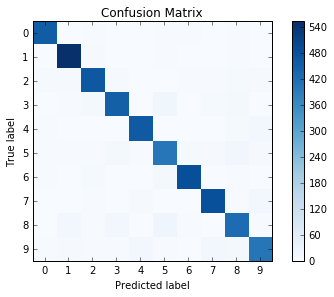

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(mnist.validation.labels, clf.predict(mnist.validation.images))

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

target_names = np.arange(10)
tick_marks = target_names
plt.xticks(tick_marks, target_names, rotation=0)
plt.yticks(tick_marks, target_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Support Vector Machine

In [15]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(mnist.train.images[:1000], mnist.train.labels[:1000])

print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 84.900%
validation accuracy: 85.360%
test accuracy: 84.560%


# Decision Trees
- [sklearn.tree.DecisionTreeClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [16]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=10)
clf.fit(mnist.train.images, mnist.train.labels)

print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 90.098%
validation accuracy: 85.800%
test accuracy: 85.480%


## BAGGING
- [sklearn.ensemble.BaggingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)
- base_estimator is cloned inside BaggingClassifier (See [BaseEnsemble._make_estimator](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/ensemble/base.py)).

In [17]:
from sklearn.ensemble import BaggingClassifier
clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), n_estimators=10)
clf.fit(mnist.train.images, mnist.train.labels)

print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 95.516%
validation accuracy: 91.940%
test accuracy: 91.840%


## Random Forests
- [sklearn.ensemble.RandomForestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- Random Forrests training is fast, easy to parallelize (n_jobs) yet the prediction performance is good. It's much faster than the original decision tree classifier.

In [18]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, n_jobs=10, max_depth=15)
clf.fit(mnist.train.images, mnist.train.labels)
None

In [19]:
print_accuracy(clf, 'train')
print_accuracy(clf, 'validation')
print_accuracy(clf, 'test')

train accuracy: 99.736%
validation accuracy: 96.200%
test accuracy: 96.400%
